# Zilch Interview - Feature EDA

This notebook will explore each of the features in the training set. The goals are:

1. Understand the underlying distribution of each feature and its relationship to the outcome variable `credit_score_target`.
2. Check each feature for errors and define the preprocessing steps required for each.
3. Begin to define some of the code necessary to build a `scikit-learn` pipeline - which is how I will transfer to the train and validation sets.

Not in scope for this notebook:

1. Model training or selection.
2. Outputting "clean" data for training.

My assumption is that the train, test and validation sets can be considered as "raw data". Therefore, any machine learning pipeline I build should handle that data in the form closest to how we receive it (presumably from some API). Thus, everything I do here will be working towards building a single `scikit-learn` pipeline object that can handle each of the datasets with no other interventions.

Likewise, I expect that a lot of the features will have many null values. In a production environment, this is the reality and so I don't want to remove any data just because it is null. There may be exceptions where the data is not MAR (missing at random). Because of this, my pipeline should be able to handle nulls - already I am thinking this is where gradient-boosting type models will be helpful.

In [855]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Live reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Since this notebook is intended just to explore the features and develop cleaning code, I will import the train and test sets and combine them. This should catch all of the errors (will lets of validation later)

In [856]:
# Import train and test data
train_df = pd.read_csv("../data/external/train.csv")
test_df = pd.read_csv("../data/external/test.csv")
combined_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [857]:
combined_df.head()

,customer_id,month,name,age,address,email,national_insurance_number,occupation,annual_income,monthly_inhand_salary,...,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score_target
0,e2239bb1-a3ad-4d04-9d2c-77334dcf8cbb,January,Lisa Wright-Phillips,23,"380 Kimberley fall, Port Nathanburgh, West Dun...",lisa.wright-phillipsmd9o@gmail.com,ZG029369J,Scientist,19114.12,1824.843333,...,26.822620,26.822620,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,721.0
1,1c6c0050-2bb2-469e-961c-583ff43d43e8,February,Dr Rachel Horton,23,"721 Amanda ports, Brianmouth, West Dunbartonsh...",dr.horton86@outlook.com,SQ701806W,Scientist,19114.12,NaN,...,31.944960,31.944960,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,726.0
2,a210a4f2-01dc-405f-841a-50e4648ea899,March,Dr Billy Burgess,-500,"604 Taylor hills, Port Samuelfurt, Aberdeenshi...",dr.burgesspx@yahoo.com,PS226897E,Scientist,19114.12,NaN,...,28.609352,28.609352,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,716.0
3,5e6aca9f-cc80-46c6-b461-c7aa6f947fd3,April,Valerie Young,23,"1 Ryan vista, Spencerport, Lincolnshire, OX15 ...",valerie.young2a63@outlook.com,XQ464206S,Scientist,19114.12,NaN,...,31.377862,31.377862,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,710.0
4,86dcfcae-ef86-47af-89c4-bb6e066b5fe0,May,Lydia Phillips,23,"5 Gardner highway, Stanleyborough, Dorset, G19...",lydia.phillipsjg@yahoo.com,KE225709Y,Scientist,19114.12,1824.843333,...,24.797347,24.797347,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,738.0


In [858]:
# Drop unnecessary columns
DROP_COLS = [
    "customer_id",
    "month",
    "name",
    "address",
    "email",
    "national_insurance_number",
]

combined_df_light = combined_df.drop(columns=DROP_COLS)
print(f"Remaining columns: {combined_df_light.columns.to_list()}")

Remaining columns: ['age', 'occupation', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan', 'type_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio', 'credit_utilization_ratio_2', 'credit_utilization_ratio_3', 'credit_history_age', 'payment_of_min_amount', 'total_emi_per_month', 'amount_invested_monthly', 'payment_behaviour', 'monthly_balance', 'credit_score_target']


## Feature EDA

I'll go through each of the remaining features and check for any errors and look at the distributions. It's also useful to plot vs. credit score here to get a better sense of the relationship.

In [859]:
# Create a DataFrame for the cleaned data
combined_df_clean = pd.DataFrame()
combined_df_clean["credit_score_target"] = combined_df_light["credit_score_target"]

### Age

In [860]:
combined_df_light["age"].describe()

count     125000
unique      2144
top           28
freq        3522
Name: age, dtype: object

First thing off the bat is that the column is not numerical, so there's probably some faulty text in there somewhere. Let's take a look.

In [861]:
# Print values where not numerical
combined_df_light["age"].apply(lambda x: x if not x.isnumeric() else None).dropna()

2         -500
8          28_
54         34_
58         30_
71         24_
          ... 
124852     40_
124878     33_
124904     22_
124969     25_
124980     47_
Name: age, Length: 7282, dtype: object

There are trailing underscores for some data and some negative values which I assume should be null. I'll write a cleaning function and apply.

In [862]:
from sklearn.base import BaseEstimator, TransformerMixin

class StringStripper(BaseEstimator, TransformerMixin):
    def __init__(self, strip_char: str = "_"):
        """Initializes the transformer with the character to strip from the string.

        Args:
            strip_char (str, optional): Character to strip. Defaults to "_".
        """
        self.strip_char = strip_char

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.replace(self.strip_char, "", regex=True)
        X = X.replace("", np.nan, regex=True)
        return X.astype(float)

# Apply the transformer to the DataFrame
string_stripper = StringStripper()
combined_df_clean["age"] =  string_stripper.fit_transform(combined_df_light["age"])

In [863]:
combined_df_clean["age"].describe()

count    125000.000000
mean        109.297656
std         680.385019
min        -500.000000
25%          24.000000
50%          33.000000
75%          42.000000
max        8698.000000
Name: age, dtype: float64

Notice that there are negative values for age, and also some incorrect large values. I'll turn these to null in order to stick with my principle of not dropping data and embracing nulls.

Rather than just hard-coding a cutoff, I'll write a more flexible transformer that nullifies values outside of an IQR * scale factor (used commonly for univariate anomaly detection).

In [864]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, factor=2.5):
        self.factor = factor

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.columns:
            q1 = X[column].quantile(0.25)
            q3 = X[column].quantile(0.75)
            iqr = q3 - q1

            lower_bound = q1 - self.factor * iqr
            upper_bound = q3 + self.factor * iqr

            X[column] = X[column].apply(lambda x: x if lower_bound <= x <= upper_bound else None)
        return X

# Example usage:
outlier_remover = OutlierRemover(factor=2.5)
combined_df_clean = outlier_remover.fit_transform(combined_df_clean)

In [865]:
combined_df_clean["age"].describe()

count    121555.000000
mean         33.406104
std          10.770901
min          14.000000
25%          25.000000
50%          33.000000
75%          42.000000
max          56.000000
Name: age, dtype: float64

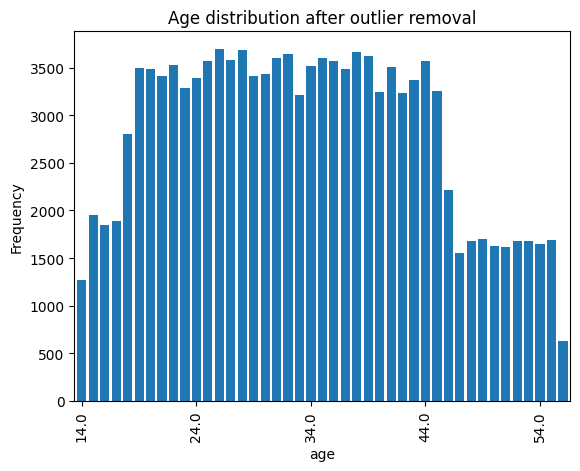

In [866]:
# Plot the age distribution after outlier removal
def plot_discrete_distribution(data: pd.Series, title: str, show_every: int = 10):
    ax = data.value_counts().sort_index().plot(kind="bar", width=0.8)
    ax.set_ylabel("Frequency")
    ax.set_xticks(ax.get_xticks()[::show_every])  # Show every 10th tick
    plt.title(title)
    plt.show()

plot_discrete_distribution(combined_df_clean["age"].dropna(), "Age distribution after outlier removal")

I'm happy with those two transformers. Hopefully by building the second one it can be re-used for some of the other features. 

Finally let's take a look at the relationship between this variable and the outcome.

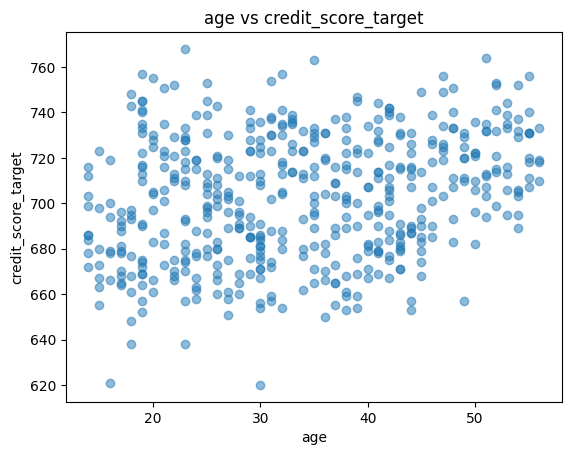

In [867]:
def plot_numerical_feature_vs_target(
    data: pd.DataFrame,
    feature: str,
    target: str = "credit_score_target",
    sample_size: int = None
):
    if sample_size:
        data = data.sample(sample_size)
    plt.scatter(data[feature], data[target], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f"{feature} vs {target}")
    plt.show()
    
plot_numerical_feature_vs_target(combined_df_clean, "age", sample_size=500)

We see a small positive correlation between age and credit score, which is what I would expect.

### Occupation

In [868]:
combined_df_light["occupation"].describe()

count      125000
unique         16
top       _______
freq         8807
Name: occupation, dtype: object

In [869]:
combined_df_light["occupation"].value_counts(dropna=False)

occupation
_______          8807
Lawyer           8242
Architect        7954
Engineer         7937
Mechanic         7891
Scientist        7837
Accountant       7831
Developer        7824
Media_Manager    7813
Teacher          7738
Entrepreneur     7716
Journalist       7620
Doctor           7600
Manager          7444
Writer           7380
Musician         7366
Name: count, dtype: int64

In [870]:
# Replace the "_______" values with "Unknown" for clarity
from sklearn.impute import SimpleImputer

blank_line_remover = SimpleImputer(missing_values="_______", strategy="constant", fill_value="Unknown")
combined_df_clean["occupation"] = blank_line_remover.fit_transform(combined_df_light[["occupation"]]).flatten()
combined_df_clean["occupation"].value_counts(dropna=False)

occupation
Unknown          8807
Lawyer           8242
Architect        7954
Engineer         7937
Mechanic         7891
Scientist        7837
Accountant       7831
Developer        7824
Media_Manager    7813
Teacher          7738
Entrepreneur     7716
Journalist       7620
Doctor           7600
Manager          7444
Writer           7380
Musician         7366
Name: count, dtype: int64

I'm happy with the quality of this in general. I'll include these in the model, would also be good to use these features to explore the model outputs later.

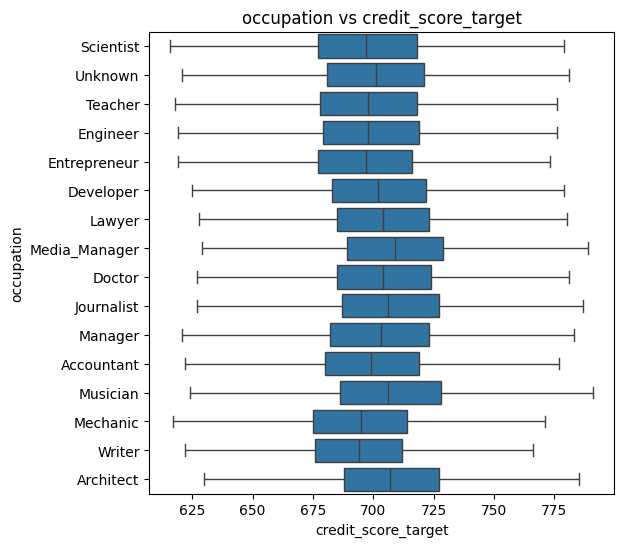

In [871]:
def plot_categorical_feature_vs_target(
    data: pd.DataFrame,
    feature: str,
    target: str = "credit_score_target",
    showfliers: bool = False
):
    # Plot boxplots for each category vs the target, horizontally
    plt.figure(figsize=(6, 6))
    sns.boxplot(x=target, y=feature, data=data, orient="h", showfliers=showfliers)
    plt.title(f"{feature} vs {target}")
    plt.show()

    
# Reset the index to avoid duplicate labels
combined_df_clean_reset = combined_df_clean.reset_index(drop=True)

plot_categorical_feature_vs_target(combined_df_clean_reset, "occupation")

Nothing much to report on here, some professions are generally higher than others but there's no obvious patterns. We'll see if a gradient boosting style model picks up on anything. This does seem like a pretty standard feature to put into the model.

### Annual Income

In [872]:
combined_df_light["annual_income"].describe()

count    1.250000e+05
mean     1.749822e+05
std      1.418062e+06
min      7.005930e+03
25%      1.943628e+04
50%      3.758034e+04
75%      7.279092e+04
max      2.419806e+07
Name: annual_income, dtype: float64

<Axes: ylabel='Frequency'>

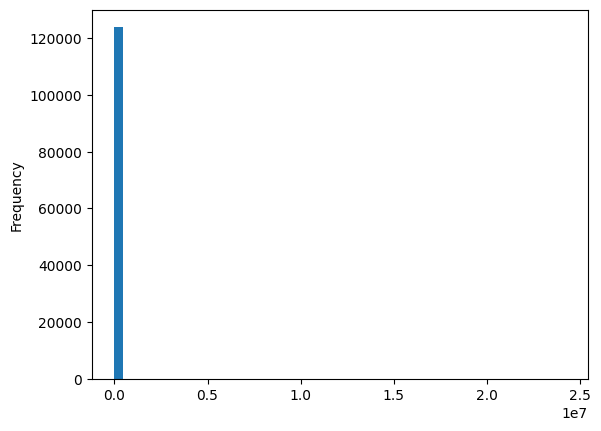

In [873]:
combined_df_light["annual_income"].plot(kind="hist", bins=50)

Getting some heavily right-skewed data for this feature. May just be the reality, I'll check the highest earners to see what's going on.

In [874]:
combined_df_light.sort_values("annual_income", ascending=False).head(1005)

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,delay_from_due_date,...,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score_target
48302,31,Engineer,24198062.0,1135.525417,4,5,5,4.0,"Personal Loan, Auto Loan, Student Loan, and Cr...",15,...,34.790192,34.790192,34.790192,18 Years and 4 Months,No,46.388945,53.573863,Low_spent_Large_value_payments,283.589734,638.0
7814,17,Lawyer,24188807.0,1067.655833,8,6,23,9.0,"Student Loan, Home Equity Loan, Student Loan, ...",47,...,41.268945,41.268945,41.268945,10 Years and 1 Months,NM,87.323423,25.385696,High_spent_Small_value_payments,254.056464,617.0
59059,21,Mechanic,24177153.0,2373.828333,4,3,6,0.0,NaN,6,...,39.408584,39.408584,39.408584,21 Years and 2 Months,No,0.000000,136.175542,Low_spent_Medium_value_payments,381.207291,630.0
14588,38,Teacher,24160009.0,3852.982500,10,6,28,8.0,"Personal Loan, Mortgage Loan, Not Specified, P...",38,...,25.225734,25.225734,25.225734,12 Years and 11 Months,Yes,196.888046,159.593972,High_spent_Medium_value_payments,278.816232,611.0
117629,37,Scientist,24137255.0,2756.167500,3,7,8,-2.0,"Credit-Builder Loan, and Home Equity Loan",5,...,23.096468,23.096468,23.096468,16 Years and 11 Months,Yes,34.081517,292.228813,Low_spent_Small_value_payments,239.306420,615.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42956,53,Accountant,5413938.0,12240.562307,5,2,1,1.0,Credit-Builder Loan,13,...,30.995167,30.995167,30.995167,28 Years and 6 Months,No,1247.053250,1257.160852,!@9#%8,248.680591,713.0
84196,52,Journalist,5394429.0,1517.921667,5,7,6,3.0,"Debt Consolidation Loan, Student Loan, and Aut...",26,...,27.480491,27.480491,27.480491,24 Years and 7 Months,Yes,41.961084,NaN,Low_spent_Large_value_payments,339.784430,694.0
38169,27,Mechanic,5388987.0,1628.530417,3,3,8,4.0,"Student Loan, Payday Loan, Payday Loan, and Ho...",27,...,26.704265,26.704265,26.704265,NaN,No,49.800524,101.666503,Low_spent_Medium_value_payments,291.386015,687.0
63686,23,Media_Manager,5368990.0,2951.107500,1,5,4,0.0,NaN,0,...,25.933561,25.933561,25.933561,17 Years and 9 Months,No,0.000000,278.359411,!@9#%8,306.751339,727.0


I'm seeing Mechanics and Teachers on £24m+ salary! I'm not saying it's *impossible*, but it's very unlikely. Let's look at those on earnings below £1m: 

<Axes: ylabel='Frequency'>

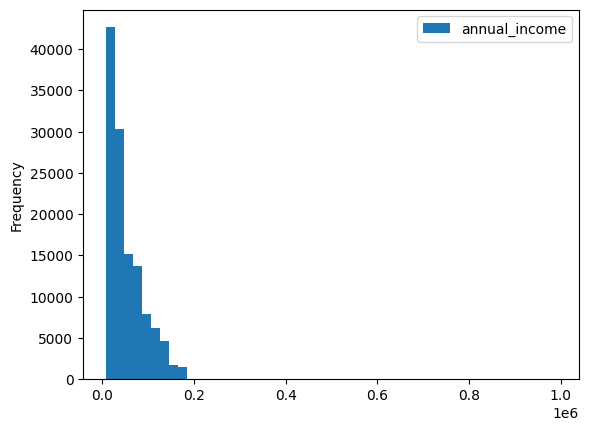

In [875]:
combined_df_light[combined_df_light["annual_income"] < 1000000].plot(kind="hist", y="annual_income", bins=50)

To me this looks like a much more sensible distribution below $200k. Since I don't want to just set an arbitrary number as the cutoff, I'll use the same outlier remover I defined previously.

<Axes: ylabel='Frequency'>

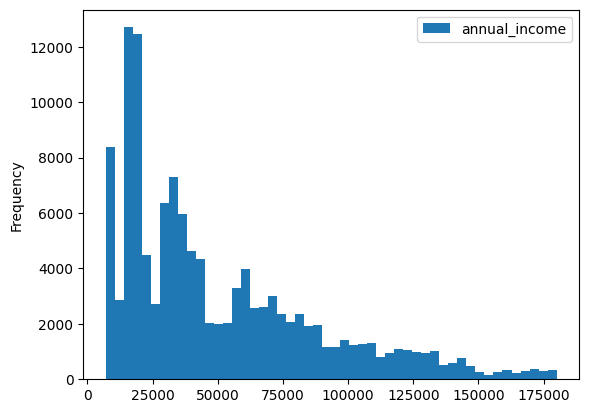

In [876]:
# Apply the outlier removal transformer to the annual_income column
combined_df_clean["annual_income"] = outlier_remover.fit_transform(combined_df_light[["annual_income"]])
combined_df_clean.plot(kind="hist", y="annual_income", bins=50)

In [877]:
combined_df_light["annual_income"].min()

7005.93

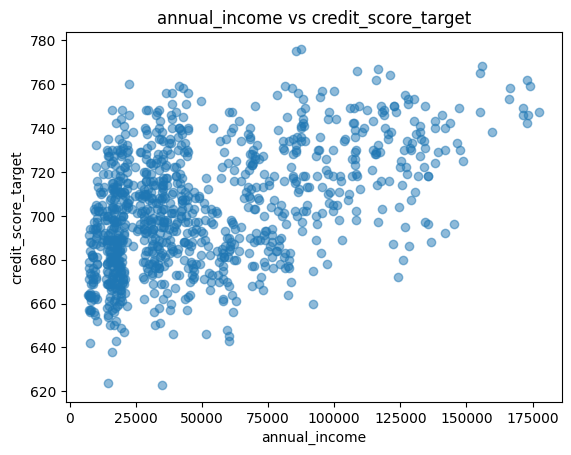

In [878]:
plot_numerical_feature_vs_target(combined_df_clean, "annual_income", sample_size=1000)

We see a positive correlation between annual income and credit score, as expected.

### Monthly Inhand Salary

In [879]:
combined_df_light["monthly_inhand_salary"].describe()

count    106279.000000
mean       4193.312938
std        3184.400956
min         303.645417
25%        1625.023750
50%        3091.260833
75%        5954.646667
max       15204.633333
Name: monthly_inhand_salary, dtype: float64

<Axes: ylabel='Frequency'>

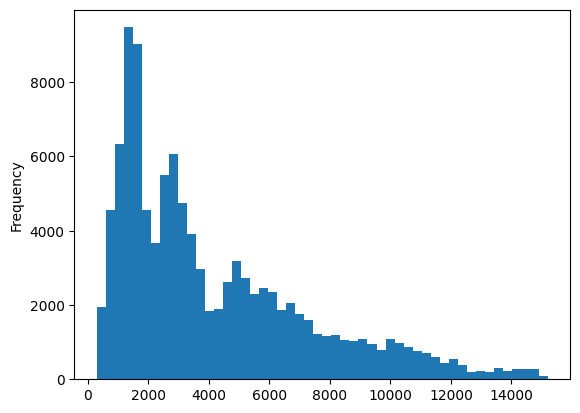

In [880]:
combined_df_light["monthly_inhand_salary"].plot(kind="hist", bins=50)

This one looks fine to me, there's always a chance that in production this feature produces some outliers, so it's probably best to run it through my function from before.

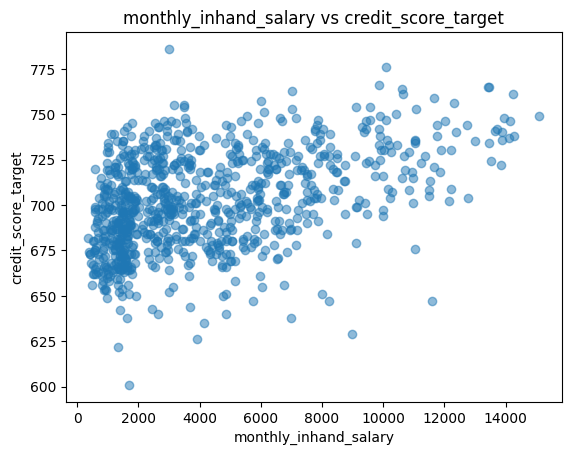

In [881]:
combined_df_clean["monthly_inhand_salary"] = outlier_remover.fit_transform(combined_df_light[["monthly_inhand_salary"]])
plot_numerical_feature_vs_target(combined_df_clean, "monthly_inhand_salary", sample_size=1000)

## Number of bank accounts

In [882]:
combined_df_light["num_bank_accounts"].describe()

count    125000.000000
mean         17.018472
std         116.865513
min          -1.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: num_bank_accounts, dtype: float64

Again, some really unusually large values for number of bank accounts, I'll apply the same outlier function as before. Also looks like like "-1" is supposed to be a null. Also, how can people have "0" bank accounts?

In [883]:
combined_df_light[combined_df_light["num_bank_accounts"] == 0].sample(10)

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,delay_from_due_date,...,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score_target
21747,47,Engineer,31254.230,2665.519167,0,6,4,4.0,"Credit-Builder Loan, Not Specified, Mortgage L...",7,...,24.111722,24.111722,24.111722,29 Years and 10 Months,No,74.503617,238.293994,Low_spent_Large_value_payments,223.754305,744.0
97463,46,Scientist,121881.240,10126.770000,0,3,2,4.0,"Personal Loan, Home Equity Loan, Auto Loan, an...",4,...,39.194857,39.194857,39.194857,16 Years and 10 Months,No,388.600435,251.219545,High_spent_Large_value_payments,612.857020,747.0
110629,55,Teacher,43924.040,3811.336667,0,6,6,-2.0,"Payday Loan, and Student Loan",5,...,23.059875,23.059875,23.059875,20 Years and 7 Months,No,63.313421,74.470691,High_spent_Large_value_payments,483.349555,732.0
85478,39,Teacher,30178.340,2557.861667,0,4,5,0.0,NaN,10,...,36.819294,36.819294,36.819294,32 Years and 2 Months,No,0.000000,87.961158,Low_spent_Medium_value_payments,447.825009,715.0
98427,40,Accountant,40878.850,3440.570833,0,5,11,4.0,"Student Loan, Student Loan, Mortgage Loan, and...",4,...,34.714850,34.714850,34.714850,24 Years and 2 Months,No,105.017091,NaN,Low_spent_Small_value_payments,180.148257,728.0
42872,46,Journalist,84045.990,6800.832500,0,3,5,0.0,NaN,1,...,26.309744,26.309744,26.309744,19 Years and 10 Months,NM,0.000000,155.220725,High_spent_Large_value_payments,764.862525,754.0
78472,48,Doctor,19641.665,1795.805417,0,6,10,0.0,NaN,15,...,37.608303,37.608303,37.608303,29 Years and 7 Months,NM,0.000000,60.672233,High_spent_Small_value_payments,378.908309,712.0
78183,22,Entrepreneur,22320.325,1966.027083,0,7,9,3.0,"Student Loan, Auto Loan, and Mortgage Loan",22,...,33.724030,33.724030,33.724030,19 Years and 3 Months,No,40.926980,123.775018,Low_spent_Small_value_payments,321.900711,727.0
76175,52,Journalist,89607.240,7256.270000,0,5,12,2.0,"Student Loan, and Credit-Builder Loan",12,...,38.361580,38.361580,38.361580,30 Years and 2 Months,NM,147.847009,57.367818,High_spent_Large_value_payments,760.412173,765.0
106468,50,Engineer,21905.095,1787.424583,0,4,6,-1.0,Student Loan,5,...,29.618155,29.618155,29.618155,32 Years and 4 Months,No,17.201641,72.183296,Low_spent_Small_value_payments,379.357521,728.0


While it feels strange that some users have no bank account, my intuition tells me that this is not MAR - there's probably a reason why some users go down as not having one. Likewise the "-1" is a special value and shouldn't be imputed. I'll apply my outlier remover though.

In [884]:
combined_df_clean["num_bank_accounts"] = outlier_remover.fit_transform(combined_df_light[["num_bank_accounts"]])
combined_df_clean["num_bank_accounts"].describe()

count    123363.000000
mean          5.366309
std           2.594577
min          -1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          11.000000
Name: num_bank_accounts, dtype: float64

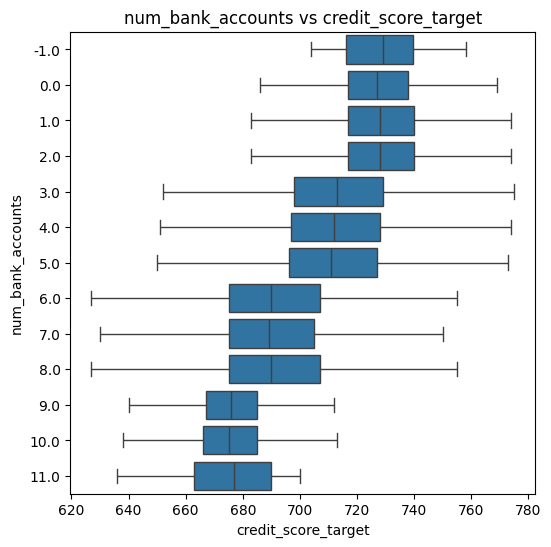

In [885]:
plot_categorical_feature_vs_target(combined_df_clean, "num_bank_accounts")

As expected - "0" and "-1" probably carries some meaning.

### Number of credit cards

In [886]:
combined_df_light["num_credit_card"].describe()

count    125000.000000
mean         22.773520
std         129.805984
min           0.000000
25%           4.000000
50%           6.000000
75%           7.000000
max        1499.000000
Name: num_credit_card, dtype: float64

Same again, apply outlier removal.

In [887]:
combined_df_clean["num_credit_card"] = outlier_remover.fit_transform(combined_df_light[["num_credit_card"]])
combined_df_clean["num_credit_card"].describe()

count    122110.000000
mean          5.538940
std           2.069394
min           0.000000
25%           4.000000
50%           5.000000
75%           7.000000
max          11.000000
Name: num_credit_card, dtype: float64

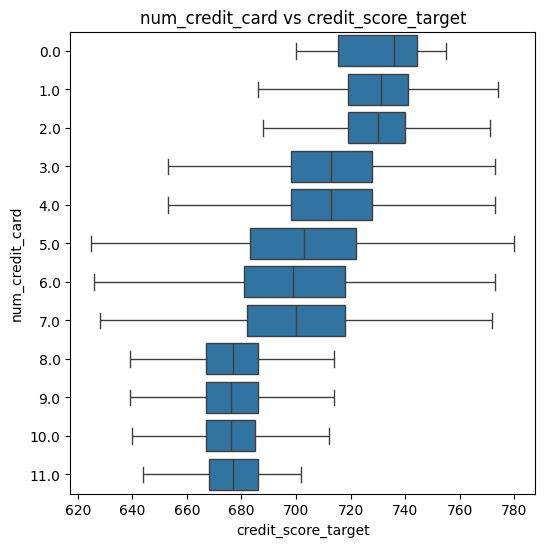

In [888]:
plot_categorical_feature_vs_target(combined_df_clean, "num_credit_card")

### Interest rate

In [889]:
combined_df_light["interest_rate"].describe()

count    125000.000000
mean         72.352520
std         466.283354
min           1.000000
25%           8.000000
50%          13.000000
75%          20.000000
max        5799.000000
Name: interest_rate, dtype: float64

A bit of a pattern here! It is useful though because I can keep applying the same function, this will make it easier when I build a pipeline later.

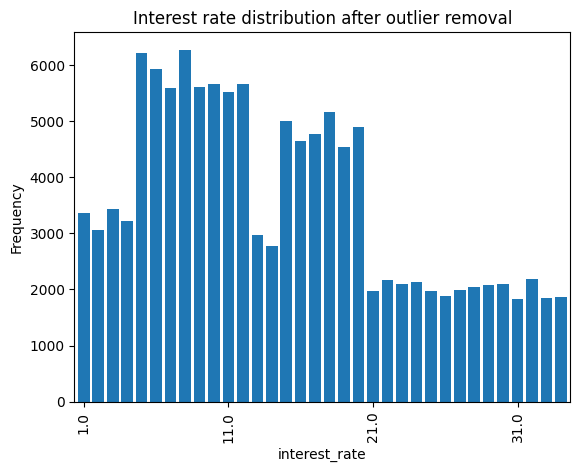

In [890]:
combined_df_clean["interest_rate"] = outlier_remover.fit_transform(combined_df_light[["interest_rate"]])
plot_discrete_distribution(combined_df_clean["interest_rate"].dropna(), "Interest rate distribution after outlier removal")

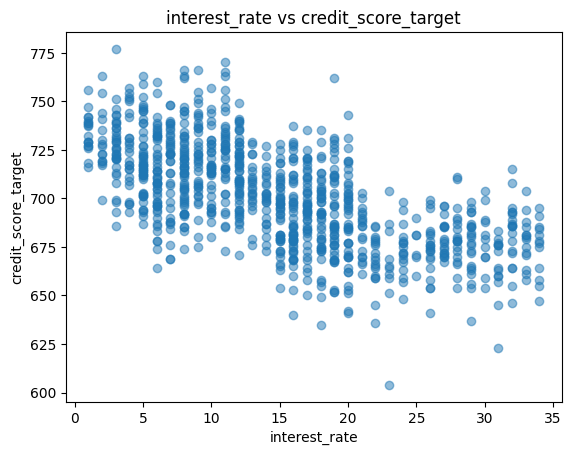

In [891]:
plot_numerical_feature_vs_target(combined_df_clean, "interest_rate", sample_size=1000)

Interest rates are negatively correlated with credit score as expected.

### Number of loans

In [892]:
combined_df_light["num_of_loan"].describe()

count    125000.000000
mean          1.810328
std          62.405262
min       -1496.000000
25%          -0.000000
50%           2.000000
75%           4.000000
max        1496.000000
Name: num_of_loan, dtype: float64

Same deal as before. Also -100 should be NaN. 

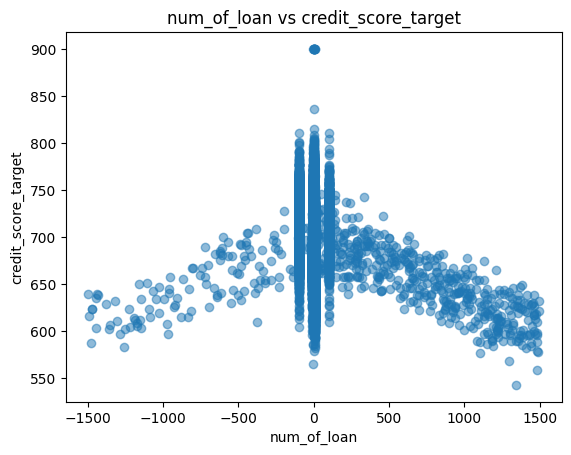

In [893]:
plot_numerical_feature_vs_target(combined_df_light, "num_of_loan")

This is strange. I'm not sure I believe that people can 1400 loans, but it does look like there's a clear trend that number of loans negatively correlates with credit score. I'm going to leave this one be. I'll impute "-100" as null though.

In [894]:
minus_100_remover = SimpleImputer(missing_values=-100, strategy="constant", fill_value=None)
combined_df_clean["num_of_loan"] = minus_100_remover.fit_transform(combined_df_light[["num_of_loan"]])
combined_df_clean["num_of_loan"].describe()

count    125000.000000
mean          4.911128
std          59.694993
min       -1496.000000
25%           0.000000
50%           2.000000
75%           4.000000
max        1496.000000
Name: num_of_loan, dtype: float64

### Type of Loan

In [895]:
combined_df_light["type_of_loan"].value_counts(dropna=False).head(20)

type_of_loan
NaN                                         14221
Not Specified                                1768
Credit-Builder Loan                          1593
Personal Loan                                1592
Debt Consolidation Loan                      1577
Student Loan                                 1557
Payday Loan                                  1503
Mortgage Loan                                1460
Home Equity Loan                             1424
Auto Loan                                    1424
Personal Loan, and Student Loan               396
Not Specified, and Payday Loan                346
Mortgage Loan, and Home Equity Loan           322
Payday Loan, and Debt Consolidation Loan      313
Student Loan, and Payday Loan                 310
Credit-Builder Loan, and Not Specified        309
Student Loan, and Credit-Builder Loan         308
Payday Loan, and Auto Loan                    299
Personal Loan, and Credit-Builder Loan        296
Payday Loan, and Student Loan        

This is going to be a bit of a pain, there is a text string in plain English saying what kind of loan there is. I'm going to split them out into binary columns which mark if the customer has that type of loan. Luckily there are only 8 types of loan, the rest are just combinations of them.

In [896]:
TYPES_OF_LOAN = [
    "Not Specified",
    "Credit-Builder Loan",
    "Personal Loan",
    "Debt Consolidation Loan",
    "Student Loan",
    "Payday Loan",
    "Mortgage Loan",
    "Auto Loan",
    "Home Equity Loan"
]

In [897]:
combined_df_light["type_of_loan"]

0         Auto Loan, Credit-Builder Loan, Personal Loan,...
1         Auto Loan, Credit-Builder Loan, Personal Loan,...
2         Auto Loan, Credit-Builder Loan, Personal Loan,...
3         Auto Loan, Credit-Builder Loan, Personal Loan,...
4         Auto Loan, Credit-Builder Loan, Personal Loan,...
                                ...                        
124995             Payday Loan, Student Loan, and Auto Loan
124996    Home Equity Loan, Debt Consolidation Loan, Pay...
124997    Debt Consolidation Loan, Mortgage Loan, and No...
124998    Home Equity Loan, Credit-Builder Loan, and Deb...
124999     Credit-Builder Loan, and Debt Consolidation Loan
Name: type_of_loan, Length: 125000, dtype: object

In [898]:
class LoanTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, loan_types=None):
        if loan_types is None:
            loan_types = [
                "Not Specified",
                "Credit-Builder Loan",
                "Personal Loan",
                "Debt Consolidation Loan",
                "Student Loan",
                "Payday Loan",
                "Mortgage Loan",
                "Auto Loan",
                "Home Equity Loan"
            ]
        self.loan_types = loan_types

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.fillna("")
        for loan_type in self.loan_types:
            X[loan_type] = X["type_of_loan"].apply(lambda x: x.count(loan_type))
        X = X.iloc[:, 1:]
        return X     

# Apply the transformer to the DataFrame
loan_type_transformer = LoanTypeTransformer()
combined_df_clean[TYPES_OF_LOAN] = loan_type_transformer.fit_transform(combined_df_light[["type_of_loan"]])

In [899]:
# Sum the binary loan columns for each row
loan_columns_sum = combined_df_clean[TYPES_OF_LOAN].sum(axis=1)

# Compare the sum to the num_of_loan column
comparison = loan_columns_sum == combined_df_light["num_of_loan"]

# Check if all comparisons are True
all_equal = comparison.all()

print(f"All sums equal to num_of_loan: {all_equal}")

All sums equal to num_of_loan: False


Something interesting here is that we could probably backfill the number of loans for those that are NaN. In fact, now that I think about it, the number of loans column is quite redundant. I'll drop it and instead create separate columns as counts for each type of loan.

This also gets around the issue with the high counts for number of loans.

In [900]:
combined_df_clean = combined_df_clean.drop(columns=["num_of_loan"])

### Delay from due date

<Axes: ylabel='Frequency'>

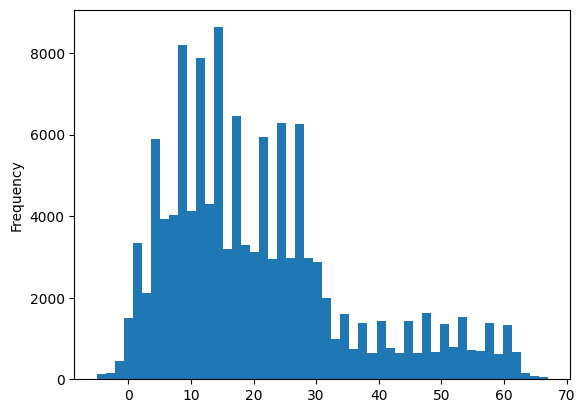

In [901]:
combined_df_light["delay_from_due_date"].plot(kind="hist", bins=50)

In [902]:
combined_df_light["delay_from_due_date"].value_counts(dropna=False).sort_index()

delay_from_due_date
-5      41
-4      87
-3     146
-2     202
-1     256
      ... 
 63     79
 64     80
 65     72
 66     40
 67     23
Name: count, Length: 73, dtype: int64

I'm going to make the assumption that minus values are okay for this feature - I'm interpreting it as they pay early (or might be classical special values from credit bureaus?). Everything else looks fine.

In [903]:
combined_df_clean["delay_from_due_date"] = outlier_remover.fit_transform(combined_df_light[["delay_from_due_date"]])

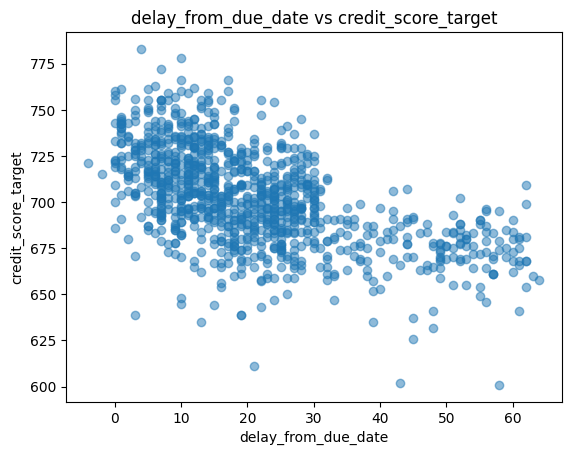

In [904]:
plot_numerical_feature_vs_target(combined_df_clean, "delay_from_due_date", sample_size=1000)

A slight negative correlation as expected.

### num_of_delayed_payment

In [905]:
combined_df_light["num_of_delayed_payment"].describe()

count    116193.000000
mean         31.048953
std         226.342803
min          -3.000000
25%           9.000000
50%          14.000000
75%          18.000000
max        4397.000000
Name: num_of_delayed_payment, dtype: float64

I'll apply my outlier function here. I'm going to interpret the minuses as special values - common in credit risk, often it's better not to impute them because they actually carry some meaning.

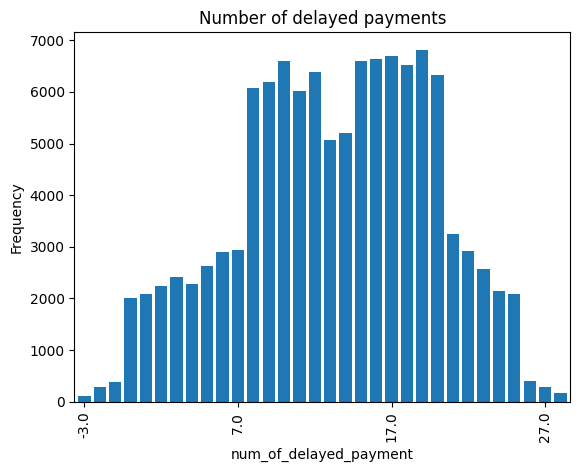

In [906]:
combined_df_clean["num_of_delayed_payment"] = outlier_remover.fit_transform(combined_df_light[["num_of_delayed_payment"]])
plot_discrete_distribution(combined_df_clean["num_of_delayed_payment"].dropna(), "Number of delayed payments")

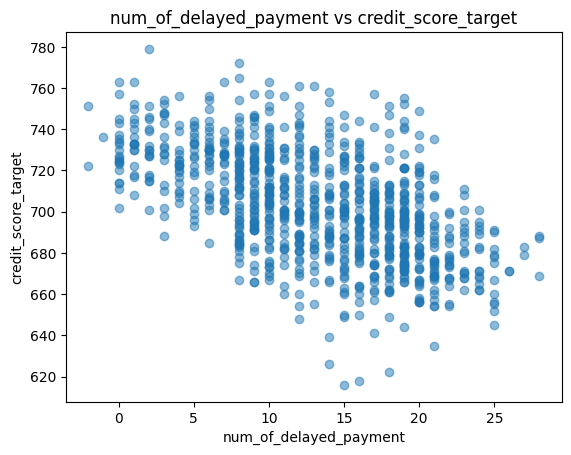

In [907]:
plot_numerical_feature_vs_target(combined_df_clean, "num_of_delayed_payment", sample_size=1000)

### changed_credit_limit

In [908]:
combined_df_light["changed_credit_limit"].describe()

count     122909
unique      7779
top            _
freq         567
Name: changed_credit_limit, dtype: object

In [909]:
# Remove underscores
combined_df_clean["changed_credit_limit"] = string_stripper.fit_transform(combined_df_light["changed_credit_limit"])

<Axes: ylabel='Frequency'>

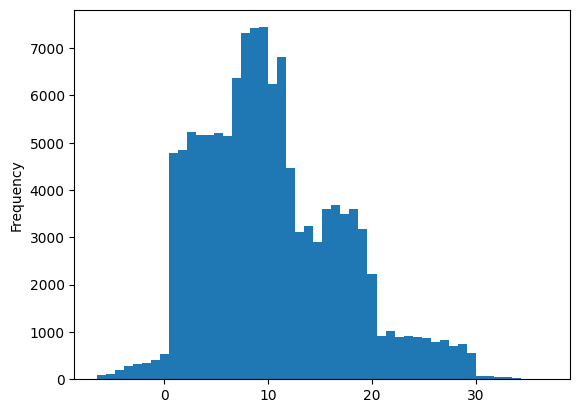

In [910]:
combined_df_clean["changed_credit_limit"].plot(kind="hist", bins=50)

Looks fine.

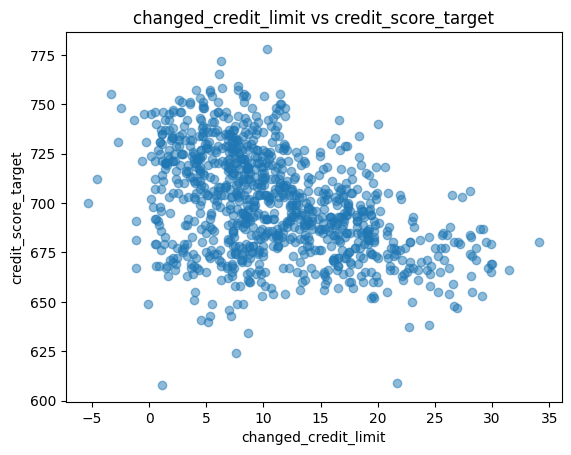

In [911]:
combined_df_clean["changed_credit_limit"] = outlier_remover.fit_transform(combined_df_clean[["changed_credit_limit"]])
plot_numerical_feature_vs_target(combined_df_clean, "changed_credit_limit", sample_size=1000)

Slight negative correlation which makes sense.

### num_credit_inquiries

In [912]:
combined_df_light["num_credit_inquiries"].describe()

count    122518.000000
mean         42.000614
std         294.564367
min           0.000000
25%           4.000000
50%           8.400000
75%          13.500000
max        5407.500000
Name: num_credit_inquiries, dtype: float64

<Axes: ylabel='Frequency'>

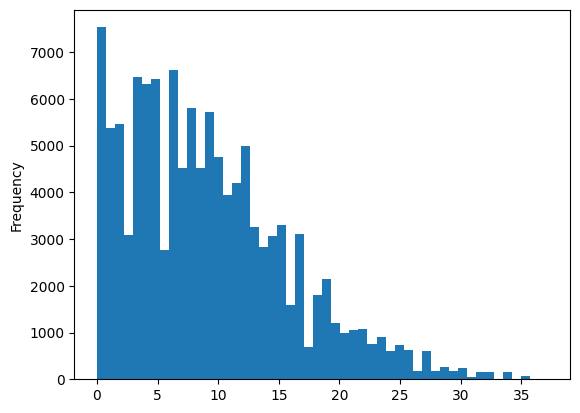

In [913]:
combined_df_clean["num_credit_inquiries"] = outlier_remover.fit_transform(combined_df_light[["num_credit_inquiries"]])
combined_df_clean["num_credit_inquiries"].plot(kind="hist", bins=50)

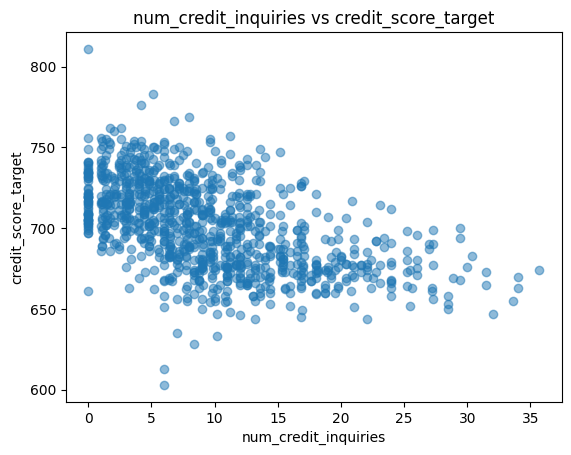

In [914]:
plot_numerical_feature_vs_target(combined_df_clean, "num_credit_inquiries", sample_size=1000)

Slight negative correlation as expected.

### outstanding_debt

In [915]:
combined_df_light["outstanding_debt"].describe()

count    125000.000000
mean        854.137902
std        1626.232257
min       -4998.070000
25%         146.900000
50%         861.190000
75%        1532.410000
max        4998.070000
Name: outstanding_debt, dtype: float64

Looks fine to me - a bit strange that it looks like a step function but that's ok. 

<Axes: ylabel='Frequency'>

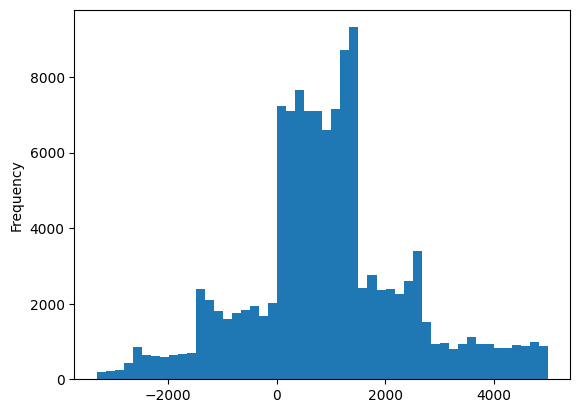

In [916]:
combined_df_clean["outstanding_debt"] = outlier_remover.fit_transform(combined_df_light[["outstanding_debt"]])
combined_df_clean["outstanding_debt"].plot(kind="hist", bins=50)

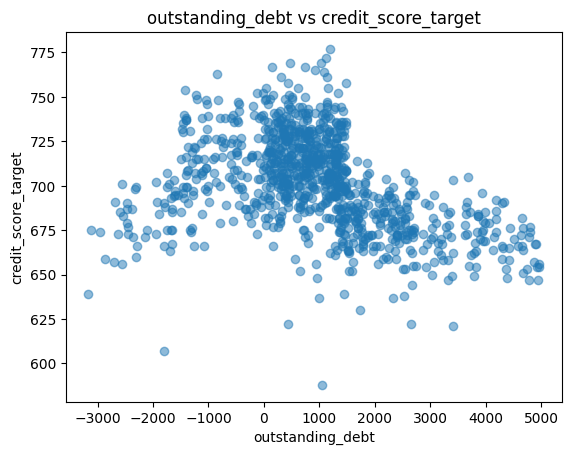

In [917]:
plot_numerical_feature_vs_target(combined_df_clean, "outstanding_debt", sample_size=1000)

Slight negative correlation - again what I would expect.

### credit_utilization_ratio

In [918]:
combined_df_light["credit_utilization_ratio"].describe()

count    125000.000000
mean         32.289935
std           5.118890
min          20.000000
25%          28.053560
50%          32.308992
75%          36.499292
max          50.000000
Name: credit_utilization_ratio, dtype: float64

<Axes: ylabel='Frequency'>

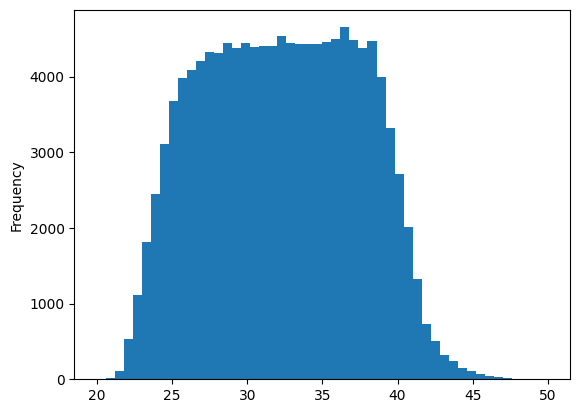

In [919]:
combined_df_light["credit_utilization_ratio"].plot(kind="hist", bins=50)

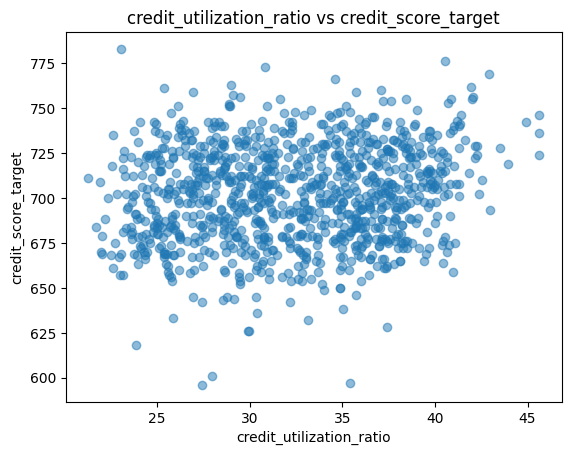

In [920]:
combined_df_clean["credit_utilization_ratio"] = outlier_remover.fit_transform(combined_df_light[["credit_utilization_ratio"]])
plot_numerical_feature_vs_target(combined_df_clean, "credit_utilization_ratio", sample_size=1000)

I'm not seeing much correlation here but perhaps there are some unseen non-linear relationships that a model will pick up.

### credit_utilization_ratio_2

<Axes: ylabel='Frequency'>

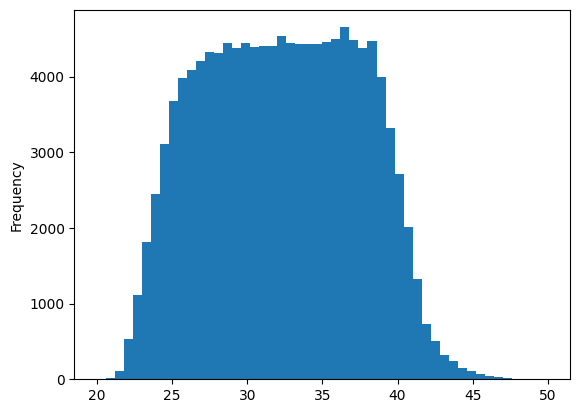

In [921]:
combined_df_light["credit_utilization_ratio_2"].plot(kind="hist", bins=50)

Are they the same?

In [922]:
combined_df_light[["credit_utilization_ratio", "credit_utilization_ratio_2", "credit_utilization_ratio_3"]]

,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3
0,26.822620,26.822620,26.822620
1,31.944960,31.944960,31.944960
2,28.609352,28.609352,28.609352
3,31.377862,31.377862,31.377862
4,24.797347,24.797347,24.797347
...,...,...,...
124995,40.034173,40.034173,40.034173
124996,29.580239,29.580239,29.580239
124997,38.929750,38.929750,38.929750
124998,35.457369,35.457369,35.457369


In [923]:
credit_util_comparison = (combined_df_light["credit_utilization_ratio"] == combined_df_light["credit_utilization_ratio_2"]) & \
                         (combined_df_light["credit_utilization_ratio_2"] == combined_df_light["credit_utilization_ratio_3"])

all_credit_util_equal = credit_util_comparison.all()

print(f"All credit utilization ratios are the same: {all_credit_util_equal}")

All credit utilization ratios are the same: True


They're the same, no need for 2 and 3.

### credit_history_age

In [924]:
combined_df_light["credit_history_age"].value_counts(dropna=False).sort_index()

credit_history_age
0 Years and 1 Months         2
0 Years and 10 Months       87
0 Years and 11 Months       82
0 Years and 2 Months        15
0 Years and 3 Months        20
                         ...  
9 Years and 6 Months       281
9 Years and 7 Months       267
9 Years and 8 Months       304
9 Years and 9 Months       319
NaN                      11260
Name: count, Length: 409, dtype: int64

This would be better suited as a numerical column.

In [925]:
class CreditHistoryAgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.apply(self.parse_credit_history_age)
        return X

    @staticmethod
    def parse_credit_history_age(age_string: str) -> int:
        """Parses a string to extract an integer credit history age value.
        
        Args:
            age_string (str): The string containing the credit history age value.
            
        Returns:
            int: The parsed integer credit history age value.
        """
        try:
            years = int(age_string.split(" ")[0])
        except (AttributeError, ValueError, IndexError):
            return None
        
        try:
            months = int(age_string.split(" ")[3])
        except (AttributeError, ValueError, IndexError):
            return 0
            
        return years * 12 + months

# Apply the transformer to the DataFrame
credit_history_age_transformer = CreditHistoryAgeTransformer()
combined_df_clean["credit_history_age"] = credit_history_age_transformer.fit_transform(combined_df_light["credit_history_age"])

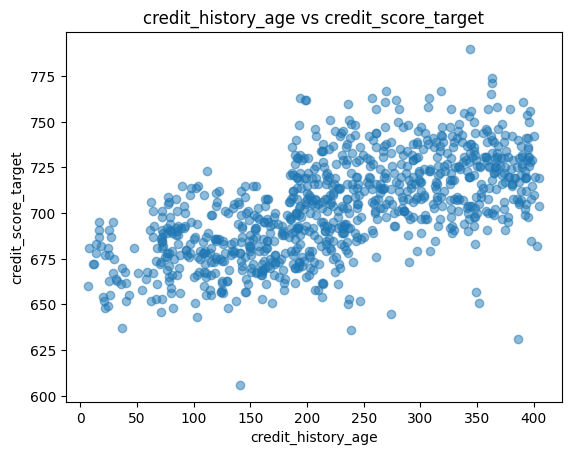

In [926]:
plot_numerical_feature_vs_target(combined_df_clean, "credit_history_age", sample_size=1000)

Makes sense to me.

### payment_of_min_amount

In [927]:
combined_df_light["payment_of_min_amount"].value_counts(dropna=False).sort_index()

payment_of_min_amount
NM     15013
No     44548
Yes    65439
Name: count, dtype: int64

Nothing to do here, I'm assuming NM is just a null value.

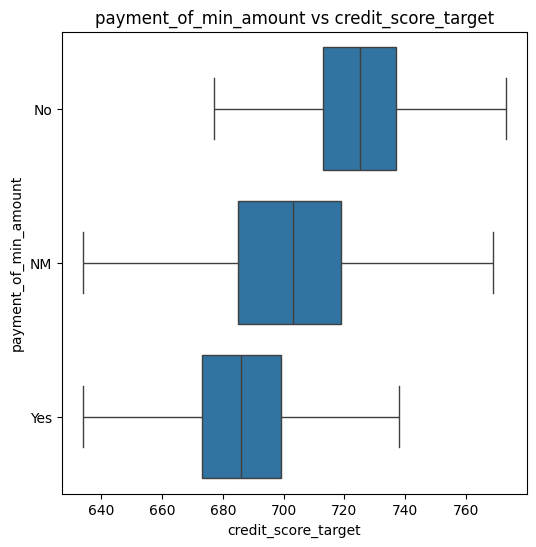

In [928]:
combined_df_clean["payment_of_min_amount"] = combined_df_light["payment_of_min_amount"]
plot_categorical_feature_vs_target(combined_df_clean, "payment_of_min_amount")

Makes sense again.

### total_emi_per_month

In [929]:
combined_df_light["total_emi_per_month"].describe()

count    125000.000000
mean       1420.440827
std        8359.643135
min           0.000000
25%          30.710142
50%          70.536064
75%         164.807470
max       82331.000000
Name: total_emi_per_month, dtype: float64

<Axes: ylabel='Frequency'>

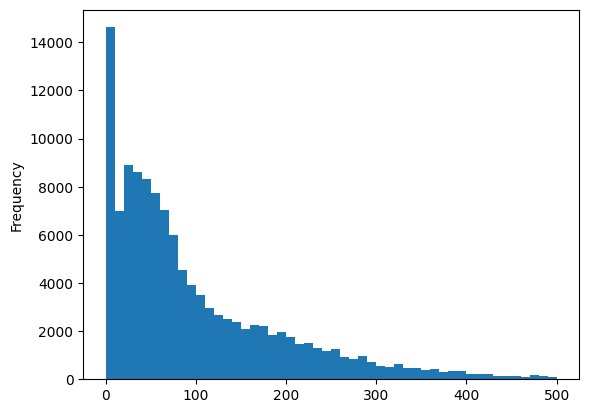

In [930]:
combined_df_clean["total_emi_per_month"] = outlier_remover.fit_transform(combined_df_light[["total_emi_per_month"]])
combined_df_clean["total_emi_per_month"].plot(kind="hist", bins=50)

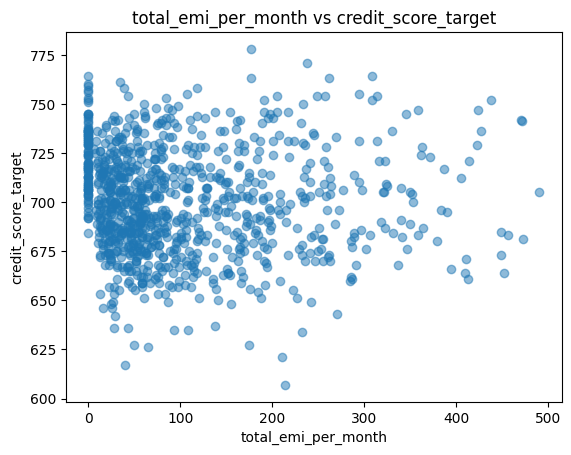

In [931]:
plot_numerical_feature_vs_target(combined_df_clean, "total_emi_per_month", sample_size=1000)

### amount_invested_monthly

In [932]:
combined_df_light["amount_invested_monthly"].describe()

count    119374.000000
mean        637.753688
std        2043.965613
min           0.000000
25%          74.558534
50%         136.100225
75%         266.389315
max       10000.000000
Name: amount_invested_monthly, dtype: float64

In [933]:
combined_df_light[combined_df_light["amount_invested_monthly"] > 8000].sample(5)

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,delay_from_due_date,...,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score_target
39919,55_,Writer,141219.08,11761.256667,5,7,11,0.0,NaN,12,...,40.320114,40.320114,40.320114,NaN,No,0.000000,10000.0,Low_spent_Small_value_payments,461.925750,698.0
28519,21_,_______,120479.64,9968.970000,2,7,8,2.0,"Not Specified, and Payday Loan",15,...,38.858803,38.858803,38.858803,17 Years and 11 Months,No,129.178003,10000.0,!@9#%8,179.672877,716.0
55654,4000,Mechanic,93890.61,7717.217500,7,6,5,4.0,"Personal Loan, Mortgage Loan, Debt Consolidati...",11,...,35.750674,35.750674,35.750674,11 Years and 1 Months,Yes,233.584663,10000.0,High_spent_Small_value_payments,288.208822,669.0
90035,38,Mechanic,7895.62,834.968333,6,6,28,6.0,"Personal Loan, Student Loan, Auto Loan, Mortga...",26,...,27.097695,27.097695,27.097695,1 Years and 11 Months,Yes,22.963678,10000.0,Low_spent_Small_value_payments,246.246512,623.0
100882,25,_______,66252.00,5261.000000,8,10,23,-7.0,"Mortgage Loan, Personal Loan, Credit-Builder L...",26,...,24.560914,24.560914,24.560914,12 Years and 2 Months,NM,303.026936,10000.0,High_spent_Small_value_payments,177.288412,653.0


The spike at 10k doesn't seem right to be me, there are people putting aside £10k each month on £26k salaries. I'll apply my function agaain.

<Axes: ylabel='Frequency'>

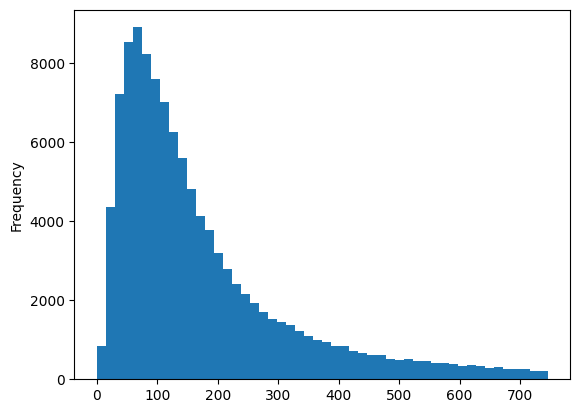

In [934]:
combined_df_clean["amount_invested_monthly"] = outlier_remover.fit_transform(combined_df_light[["amount_invested_monthly"]])
combined_df_clean["amount_invested_monthly"].plot(kind="hist", bins=50)

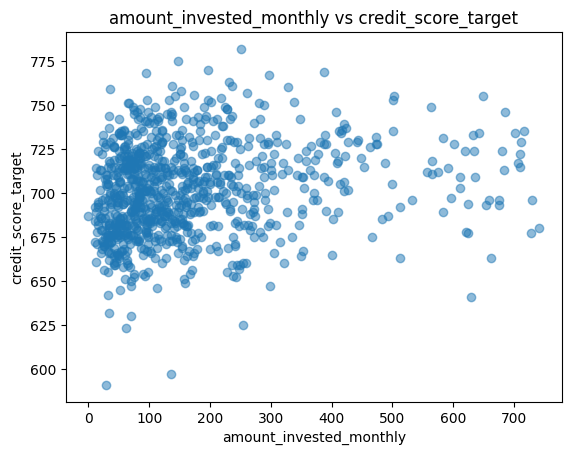

In [935]:
plot_numerical_feature_vs_target(combined_df_clean, "amount_invested_monthly", sample_size=1000)

### payment_behaviour

In [936]:
combined_df_light["payment_behaviour"].value_counts(dropna=False).sort_index()

payment_behaviour
!@9#%8                               9517
High_spent_Large_value_payments     17160
High_spent_Medium_value_payments    21958
High_spent_Small_value_payments     14143
Low_spent_Large_value_payments      12971
Low_spent_Medium_value_payments     17300
Low_spent_Small_value_payments      31951
Name: count, dtype: int64

In [937]:
# Remove that weird value
garbage_remover = SimpleImputer(missing_values="!@9#%8", strategy="constant", fill_value=None)
combined_df_clean["payment_behaviour"] = garbage_remover.fit_transform(combined_df_light[["payment_behaviour"]]).flatten()

In [938]:
combined_df_clean["payment_behaviour"].value_counts(dropna=False).sort_index()

payment_behaviour
High_spent_Large_value_payments     17160
High_spent_Medium_value_payments    21958
High_spent_Small_value_payments     14143
Low_spent_Large_value_payments      12971
Low_spent_Medium_value_payments     17300
Low_spent_Small_value_payments      31951
missing_value                        9517
Name: count, dtype: int64

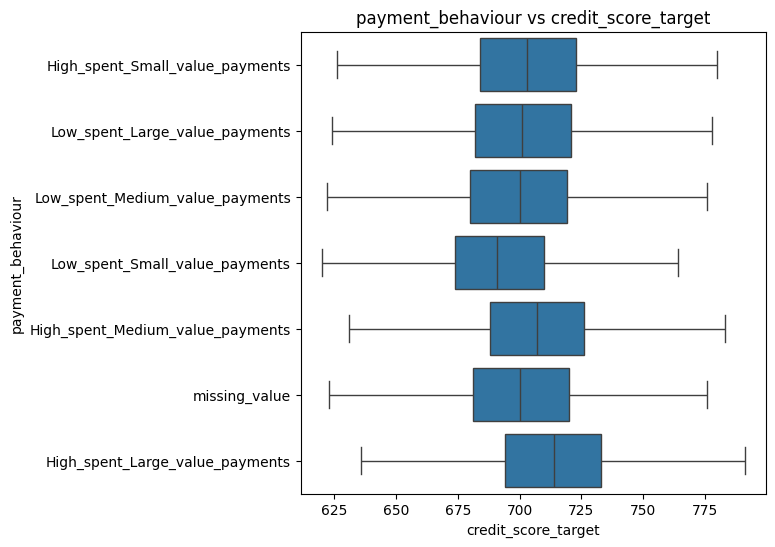

In [939]:
plot_categorical_feature_vs_target(combined_df_clean, "payment_behaviour")

### monthly_balance

In [940]:
combined_df_light["monthly_balance"].describe()

count    1.235340e+05
mean    -2.698312e+22
std      2.998953e+24
min     -3.333333e+26
25%      2.700024e+02
50%      3.364417e+02
75%      4.703105e+02
max      1.602041e+03
Name: monthly_balance, dtype: float64

<Axes: ylabel='Frequency'>

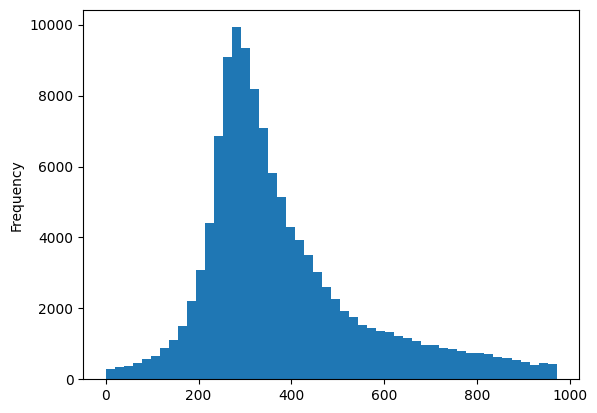

In [941]:
combined_df_clean["monthly_balance"] = outlier_remover.fit_transform(combined_df_light[["monthly_balance"]])
combined_df_clean["monthly_balance"].plot(kind="hist", bins=50)

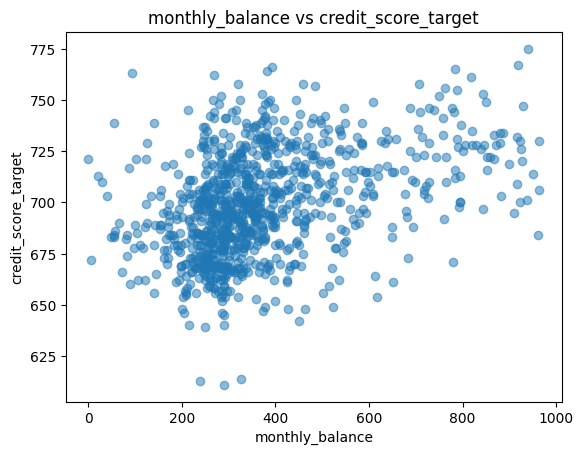

In [942]:
plot_numerical_feature_vs_target(combined_df_clean, "monthly_balance", sample_size=1000)

### credit_score_target

<Axes: ylabel='Frequency'>

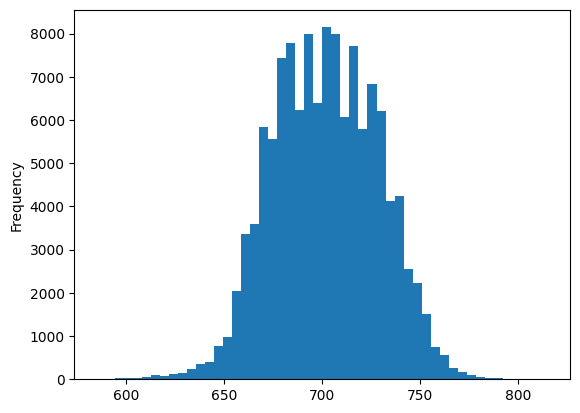

In [943]:
combined_df_clean["credit_score_target"].plot(kind="hist", bins=50)

In [944]:
combined_df_clean["credit_score_target"].isna().sum()

25

In [945]:
combined_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   credit_score_target       124975 non-null  float64
 1   age                       121555 non-null  float64
 2   occupation                125000 non-null  object 
 3   annual_income             123750 non-null  float64
 4   monthly_inhand_salary     106279 non-null  float64
 5   num_bank_accounts         123363 non-null  float64
 6   num_credit_card           122110 non-null  float64
 7   interest_rate             122475 non-null  float64
 8   Not Specified             125000 non-null  int64  
 9   Credit-Builder Loan       125000 non-null  int64  
 10  Personal Loan             125000 non-null  int64  
 11  Debt Consolidation Loan   125000 non-null  int64  
 12  Student Loan              125000 non-null  int64  
 13  Payday Loan               125000 non-null  i

In [946]:
combined_df_clean.head()

,credit_score_target,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,Not Specified,Credit-Builder Loan,...,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance
0,721.0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,0,1,...,11.27,4.0,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089
1,726.0,23.0,Scientist,19114.12,NaN,3.0,4.0,3.0,0,1,...,11.27,4.4,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162
2,716.0,NaN,Scientist,19114.12,NaN,3.0,4.0,3.0,0,1,...,NaN,4.8,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863
3,710.0,23.0,Scientist,19114.12,NaN,3.0,4.0,3.0,0,1,...,6.27,5.2,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310
4,738.0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,0,1,...,11.27,5.6,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231


In [947]:
combined_df_clean["age"].describe()

count    121555.000000
mean         33.406104
std          10.770901
min          14.000000
25%          25.000000
50%          33.000000
75%          42.000000
max          56.000000
Name: age, dtype: float64

Next, I'll define all of the above in a custom transformer class (in `zilch_interview/prepare.py`) so I can use it consistently across the project.

In [948]:
from zilch_interview.prepare import DataCleaner

data_cleaner = DataCleaner()
train_df_transformed = data_cleaner.fit_transform(combined_df)

In [949]:
# Check that the two transformed DataFrames are equal
train_df_transformed.equals(combined_df_clean[train_df_transformed.columns])

True

I'm happy that that custom cleaner is working as expected.